# Import packages

In [1]:
# Pytorch packages
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision.transforms import transforms
from torchinfo import summary

import os
import pandas as pd

import glob
import csv
import numpy as np
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

# Plotting
import matplotlib.pyplot as plt

# Read the data

## Create the custom data loader

In [2]:
# Custom dataset class
class FileDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.file_list = []
        self.labels = []
        
        # The number of classes
        self.n_classes = 0

        # Extract file paths and labels
        self._extract_file_paths()
        
         # Perform label encoding as one-hot encoding
        self._encode_labels()

    def __len__(self):
        return len(self.file_list)

    def __getitem__(self, idx):
        file_path = self.file_list[idx]
        label = self.labels[idx]

        # Read the file
        data = self._read_file(file_path)

        # Apply transformation if provided
        if self.transform:
            data = self.transform(data)

        return data, label

    def _extract_file_paths(self):
        label_dirs = os.listdir(self.root_dir)

        for label in label_dirs:
            label_dir = os.path.join(self.root_dir, label)
            if os.path.isdir(label_dir):
                files = glob.glob(os.path.join(label_dir, '*.csv'))
                self.file_list.extend(files)
                self.labels.extend([label] * len(files))

    def _read_file(self, file_path):
        
        signal_data = np.loadtxt(file_path, dtype=np.float32, delimiter=",")
        # Transform to torch vector and reshape to column vector
        return torch.from_numpy(signal_data)
        
        # Implement your own file reading logic here
        # For example, if you're working with CSV files, you can use pandas
        # dataframe = pd.read_csv(file_path)
        # return dataframe.values

        # In this example, we assume a simple text file and read its content
        #with open(file_path, 'r') as file:
        #    content = file.read()

        #return content
        
    def _encode_labels(self):
        
        label_encoder = LabelEncoder()
        integer_encoded = label_encoder.fit_transform(self.labels)
        
        # Print the original classes names
        #print(label_encoder.classes_)
        
        # Reshape to column vector
        integer_encoded = integer_encoded.reshape(-1, 1)

        # JCPS "sparse" deprecated in version 1.2, use "sparse_output" from version 1.4
        #onehot_encoder = OneHotEncoder(sparse=False)
        onehot_encoder = OneHotEncoder(sparse_output=False)
        
        onehot_encoded = onehot_encoder.fit_transform(integer_encoded)
        
        self.n_classes = onehot_encoded.shape[1]
        
        self.labels = torch.tensor(onehot_encoded, dtype=torch.float32)
        #self.labels = torch.tensor(onehot_encoded, dtype=torch.long)

## Define transformations for the raw data

In [3]:
# This reshape the raw data to a row vector

class ToRowVector(object):
    """Transforms the input signal to a row vector"""
    
    def __call__(self, sample):
        #reshaped_sample = sample.view(1, -1)
        #print(sample.shape[0])
        #print(sample.shape[1])
        
        # Slide the data, use only the first row
        preshaped = sample[0,:]
                        
        #reshaped_sample = sample.view(sample.shape[0]*sample.shape[1])
        reshaped_sample = preshaped.view(preshaped.shape[0])
        
        #return sample
        return reshaped_sample

## Instantiate the data loader

In [4]:
# The folder with the dataset
folder_name = "../02_python_signal_folder_sorting/sorted_signals_by_mhr"
batch_size = 10

# Create training and validation datasets
train_dataset = FileDataset(folder_name, transform=transforms.Compose([ToRowVector()]))
#train_dataset = FileDataset(folder_name)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)

# Define the Neural Network

In [5]:
# Define the neural network architecture
class BaseClassifier(nn.Module):
    def __init__(self, in_dim, out_dim):
        super(BaseClassifier, self).__init__()
           
        # Define your layers here   
        
        self.conv1 = nn.Conv2d(in_dim, 32, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(32, 16, kernel_size=3, stride=1, padding=1)
        self.fc1 = nn.Linear(16 * 8 * 8, 128)
        self.fc2 = nn.Linear(128, out_dim)
        self.relu = nn.ReLU()
        
        #self.linear1 = nn.Linear(in_dim, 128, bias=True)
        #self.linear2 = nn.Linear(128, 32)
        #self.relu = nn.ReLU()
        #self.linear3 = nn.Linear(32, out_dim)

        # HERE HERE HERE
        
        #self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1)
        #self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        #self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        #self.fc1 = nn.Linear(32 * 8 * 8, 128)
        #self.fc2 = nn.Linear(128, 10)
        #self.relu = nn.ReLU()
        
        
    def forward(self, x):
        
        # Define the forward pass of your networkloss.item())
        x = self.conv1(x)
        x = self.relu(x)
        x = self.pool(x)
        x = self.conv2(x)
        x = self.relu(x)
        x = self.pool(x)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        
        #x = self.conv1(x)
        #x = self.relu(x)
        #x = self.pool(x)
        #x = self.conv2(x)
        #x = self.relu(x)
        #x = self.pool(x)
        #x = x.view(-1, 32 * 8 * 8)
        #x = self.fc1(x)
        #x = self.relu(x)
        #x = self.fc2(x)
        
        #x = self.linear1(x)
        #x = self.relu(x)
        #x = self.linear2(x)
        #x = self.relu(x)
        #x = self.linear3(x)
                
        return x

# Instantiate the model, optimiser and hyperparameter(s)

## Set hyperparameters

In [6]:
#n_input_features = 2040000
n_input_features = 60000 # input dimension
n_output_classes = 4 # output dimension

# Define the loss function
criterion = nn.CrossEntropyLoss()

# Define the number of epochs
n_epochs = 5

# Create an instance of the neural network
net = BaseClassifier(n_input_features, n_output_classes)
    
# Define the optimiser (with its corresponding learning rate)
learning_rate = 1e-4
opt = optim.Adam(net.parameters(), lr=learning_rate)

# Summary of the model
for p in net.parameters():
    print(p.shape)

# Summary of the model
#summary(net, input_size = (batch_size, 2040000, 4))
summary(net, input_size = (batch_size, n_input_features))
#summary(net)

torch.Size([32, 60000, 3, 3])
torch.Size([32])
torch.Size([16, 32, 3, 3])
torch.Size([16])
torch.Size([128, 1024])
torch.Size([128])
torch.Size([4, 128])
torch.Size([4])


RuntimeError: Failed to run torchinfo. See above stack traces for more details. Executed layers up to: []

# Train the model

Epoch [1/5], Batch Loss: 69.65843200683594
Epoch [1/5], Batch Loss: 37.18609619140625
Epoch [1/5], Batch Loss: 104.2634506225586
Epoch [1/5], Batch Loss: 45.8179817199707
Epoch [1/5], Batch Loss: 75.56028747558594
Epoch [1/5], Batch Loss: 71.45069122314453
Epoch [1/5], Batch Loss: 67.78333282470703
Epoch [1/5], Batch Loss: 64.34171295166016
Epoch [1/5], Batch Loss: 56.43855667114258
Epoch [1/5], Batch Loss: 65.41778564453125
Epoch: 1 training loss: 65.7918327331543
Epoch [2/5], Batch Loss: 104.37730407714844
Epoch [2/5], Batch Loss: 46.42253875732422
Epoch [2/5], Batch Loss: 105.9829330444336
Epoch [2/5], Batch Loss: 53.547821044921875
Epoch [2/5], Batch Loss: 51.7826042175293
Epoch [2/5], Batch Loss: 47.91558074951172
Epoch [2/5], Batch Loss: 67.08921813964844
Epoch [2/5], Batch Loss: 63.14037322998047
Epoch [2/5], Batch Loss: 66.28764343261719
Epoch [2/5], Batch Loss: 51.37229537963867
Epoch: 2 training loss: 65.7918312072754
Epoch [3/5], Batch Loss: 61.52458572387695
Epoch [3/5], Ba

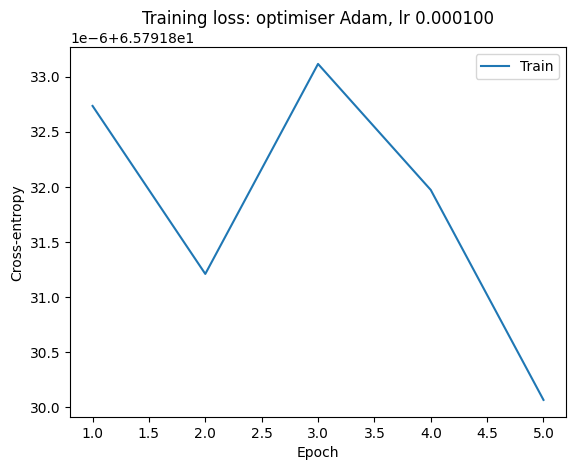

In [7]:
# Define the training method
def train(model=net,
          optimizer=opt,
          n_epochs=n_epochs,
          loss_fn=criterion,
          lr=learning_rate):
    
    # Indicate the Pytorch backend we are on training mode
    model.train()
    loss_lt = []
    
    # Training loop
    for epoch in range(n_epochs):
        running_loss = 0.0
        for batch_data, batch_labels in train_loader:
        
            # Forward pass
            outputs = model(batch_data)

            #print("Outputs\n")
            #print(outputs)
        
            #print("Batch labels\n")
            #print(batch_labels)
        
            # Compute the loss
            loss = loss_fn(outputs, batch_labels)

            # Backpropagation and optimization
            loss.backward()
        
            optimizer.zero_grad()
            optimizer.step()
                    
            # Keep track of sum of loss of each batch
            running_loss+=loss.item()
                
            # Print the loss for monitoring
            print('Epoch [{}/{}], Batch Loss: {}'.format(epoch+1, n_epochs, loss.item()))
        
        # Add the cumulative loss to a list
        loss_lt.append(running_loss/len(train_loader))
        
        # Print the total loss of the epoch
        print('Epoch: {} training loss: {}'.format(epoch+1, running_loss/len(train_loader)))
        
    plt.plot([i for i in range(1, n_epochs+1)], loss_lt, label="Train")
    plt.xlabel("Epoch")
    plt.ylabel("Cross-entropy")
    plt.title("Training loss: optimiser {}, lr {:.6f}".format("Adam", lr))
    plt.legend()
    plt.show()

# Save the trained model
#torch.save(net.state_dict(), "./trained_model/model.pt')

# Call the training method
train(net, opt, n_epochs, criterion)

# Test the model

In [8]:
# Define a helper function to generate a one-hot encoding at the position of the maximum value
def generate_max_indices_tensor(input_tensor):
    # Compute the maximum along each row
    max_values, max_indices = torch.max(input_tensor, dim=1)
    
    # Create a tensor of zeros with the same shape as the input tensor
    output_tensor = torch.zeros_like(input_tensor)
    
    # Set ones at the indices of the maximum values
    output_tensor.scatter_(1, max_indices.unsqueeze(1), 1)
    
    return output_tensor

# Define a helper function that returns a one tensor if the input tensors are equal
def compare_tensors(tensor1, tensor2):
    # Check if the tensors have the same shape
    if tensor1.shape != tensor2.shape:
        return torch.tensor([0])
    
    # Compare the elements of the tensors
    equal_elements = torch.eq(tensor1, tensor2)
    
    # Check if all elements are equal
    if torch.all(equal_elements):
        return torch.tensor([1])
    else:
        return torch.tensor([0])

# Define the testing method
def test(classifier=net,
        loss_fn=criterion):
    
    # Indicate the Pytorch backend we are on testing mode
    classifier.eval()
    accuracy = 0.0
    computed_loss = 0.0
    
    with torch.no_grad():
        for batch_data, batch_labels in test_loader:
            
            # Forward pass
            outputs = net(batch_data)
            
            #print("These are the outputs")
            #print(outputs)
            
            #print("These are the batch labels")
            #print(batch_labels)
            
            # Compute the loss
            loss = loss_fn(outputs, batch_labels)
            
            # Compute the one-hot enconding version
            one_hot_output = generate_max_indices_tensor(outputs)
            
            #print("These are the one-hot outputs")
            #print(one_hot_output)
            
            # Compute accuracy
            #accuracy+=torch.sum(compare_tensors(one_hot_output,batch_labels))
            print(accuracy)
            
        print("Test loss: {}, test accuracy: {}".format(
            loss.item()/(len(test_loader)*batch_size),
            accuracy*100.0/(len(test_loader)*batch_size)))

# Call the test method
test(net, criterion)

0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
Test loss: 0.20218904495239257, test accuracy: 0.0


# Code testing

In [ ]:
for batch_data, batch_labels in train_loader:
    print(batch_data.shape)
    print(batch_labels)
    print(batch_labels.shape)

In [ ]:
signal_data = np.loadtxt("../02_python_signal_folder_sorting/sorted_signals_by_mhr/70_74/nifecg.0003.fs_1000_mhr_72_fhr_132.csv", dtype=np.float32, delimiter=",")
signal_data_torch = torch.from_numpy(signal_data)
signal_data_torch

In [ ]:
## One-hot enconding
encoder = OneHotEncoder

In [41]:
x = torch.rand(3,4)
print(x)
idx, x_max = x.max(dim=1)
print(x_max)
x_arg_max = torch.argmax(x, 1)
print(x_arg_max)

tensor([[0.6053, 0.8904, 0.6319, 0.9525],
        [0.0125, 0.2390, 0.1449, 0.3404],
        [0.8410, 0.9001, 0.1907, 0.5939]])
tensor([3, 3, 1])
tensor([3, 3, 1])
